這邊用來存程式碼
===
請善用Ctrl+F來查詢所需函式或程式碼
---
下載完DATA記得改img路徑<br>
懶得改就直接丟C槽 <font color="red">然後資料夾名稱flowerpic</font><br>
因為我如果全部推github 要很久== 你們下載會更久:)

訓練集(DATA):https://www.kaggle.com/datasets/msheriey/104-flowers-garden-of-eden

要做的<br>
*   訓練辨識系統<br>
~Approximate Nearest Neighbor
*   資料庫<br>
maybe SQL or firebase 
*   UI介面<br>
Kivy?


訓練辨識系統
---


In [3]:
#import 丟這裡
#no moudle 請在終端機 pip install moudle 或是 python -m pip install moudle

import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image
import math
import matplotlib.pyplot as plt

In [4]:
#HSV即色相、飽和度、明度
#https://zh.wikipedia.org/zh-tw/HSL%E5%92%8CHSV%E8%89%B2%E5%BD%A9%E7%A9%BA%E9%97%B4
##看顏色##
#https://www.peko-step.com/zhtw/tool/hsvrgb.html
img="C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg"
img=cv2.imread(img)
img=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

cv2.imwrite('oxx1.jpeg', img)
cv2.waitKey(0)                              
cv2.destroyAllWindows()



PS 中

H 範圍在 0 ~ 360 。 S 範圍在 0 ~ 1 % V 範圍在 0 ~ 1 %

Python 中

H 範圍在 0 ~ 180 S 範圍在 0 ~ 255 V 範圍在 0 ~ 255

In [5]:
#顏色區分
#論文pg21 有空幫我看一下我有沒有寫錯 謝謝
HSV=[114, 134, 181]
HSV=np.array(HSV)
def HSV_differentiate(HSV):
    h=HSV[0]*2
    s=HSV[1]*100/255
    v=HSV[2]*100/255
    if  v<20:
        l=0
    elif s<20 and 20<=v<80 :
        l=math.floor(((v/100-0.2)*10))+1   
    elif s<20 and 80<=v<=100:
        l=7
    else:
        if h>22 and h<=45:
            H=1
        elif h>45 and h<=70:
            H=2
        elif h>70 and h<=155:
            H=3
        elif h>155 and h<=186:
            H=4
        elif h>186 and h<=278:
            H=5
        elif h>278 and h<=330:
            H=6
        else:H=0
        if s>20 and s<=65:
            S=0
        else:S=1
        if v>20 and v<=70:
            V=0
        else:V=1
        l=4*H+2*S+V+8
    return l

print(HSV_differentiate(HSV))

29


In [6]:
#像素
224*224

50176

In [7]:
#畫出圓形區域
def Centroid(img):
    img = cv2.imread(img)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray_image,127,255,0)
    M = cv2.moments(thresh)
    #質心
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    if cX>cY:
        radius=cY-1
    else:radius=cX-1
        
    cv2.circle(img, (cX, cY), 2, (255, 255, 255), -1)
    cv2.circle(img, (cX, cY), radius,(255, 255, 255), 0)
    cv2.circle(img, (cX, cY), radius//3,(255, 255, 255), 0)
    cv2.circle(img, (cX, cY), radius*2//3,(255, 255, 255), 0)
    print(cX,cY)
 
    cv2.imshow("Image", img)
    cv2.waitKey(0)
  
Centroid("C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg")



111 124


In [8]:
##質心半徑
def Radius(img):
    img = cv2.imread(img)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray_image,127,255,0)
    M = cv2.moments(thresh)
    #質心
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    if cX>cY:
        radius=cY-1
    else:radius=cX-1
    
    return radius
print(Radius("C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg"))
print(Radius("C:/flowerpic/jpeg-224x224/val/iris/16301.jpeg"))

110
103


In [9]:
#切割圓形區域


def Cut(img):
    name=img.split("/")
    
    img_=cv2.imread(img)
    img1=cv2.imread((img))
    img2=cv2.imread((img))
    img3=cv2.imread((img))
    #質心半徑
    r=Radius(img)
    ##遮蓋罩##
    ##最大
    #MASK1=np.zeros_like(img1)
    MASK1=np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8) 
    cv2.circle(MASK1, (111,124), r, (255, 255, 255), -1) 
    ##次之
    #MASK2=np.zeros_like(img2)
    MASK2=np.zeros((img2.shape[0], img2.shape[1]), dtype=np.uint8) 
    cv2.circle(MASK2, (111,124), r*2//3, (255, 255, 255), -1)

    ##最小 
    #MASK3=np.zeros_like(img3)
    MASK3=np.zeros((img3.shape[0], img3.shape[1]), dtype=np.uint8) 
    cv2.circle(MASK3, (111,124), r//3, (255, 255, 255), -1)
    mask2 = cv2.subtract(MASK2, MASK3)
    mask1 = cv2.subtract(MASK1, MASK2)
    
    imgAddMask1 = cv2.add(img1, np.zeros(np.shape(img1), dtype=np.uint8), mask=mask1)
    imgAddMask2 = cv2.add(img2, np.zeros(np.shape(img2), dtype=np.uint8), mask=mask2)
    imgAddMask3 = cv2.add(img3, np.zeros(np.shape(img3), dtype=np.uint8), mask=MASK3)
    cv2.imwrite("cuts/cut1_"+name[-2]+"_"+name[-1], imgAddMask1)
    cv2.imwrite("cuts/cut2_"+name[-2]+"_"+name[-1], imgAddMask2)
    cv2.imwrite("cuts/cut3_"+name[-2]+"_"+name[-1], imgAddMask3)
    
    
Cut("C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg")
Cut("C:/flowerpic/jpeg-224x224/val/iris/16301.jpeg")
# r=110

# img="C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg"
# img_=cv2.imread(img)
# img1 = cv2.imread(img)
# img2 = cv2.imread(img)
# img3 = cv2.imread(img)

# ##最大
# #MASK1=np.zeros_like(img1)
# MASK1=np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8) 
# cv2.circle(MASK1, (111,124), r, (255, 255, 255), -1) 
# ##次之
# #MASK2=np.zeros_like(img2)
# MASK2=np.zeros((img2.shape[0], img2.shape[1]), dtype=np.uint8) 
# cv2.circle(MASK2, (111,124), r*2//3, (255, 255, 255), -1)

# ##最小 
# #MASK3=np.zeros_like(img3)
# MASK3=np.zeros((img3.shape[0], img3.shape[1]), dtype=np.uint8) 
# cv2.circle(MASK3, (111,124), r//3, (255, 255, 255), -1)

# mask2 = cv2.subtract(MASK2, MASK3)
# mask1 = cv2.subtract(MASK1, MASK2)
# # # ROI
# # result2 = cv2.cvtColor(img2, cv2.COLOR_BGR2BGRA)
# # result2[:, :, 3] = mask2[:,:,0]
# # #cv2.imshow('image', result2)
# # #cv2.imshow('mask2', mask2)
# # cv2.imwrite('result2.png', result2)

# # result1 = cv2.cvtColor(img1, cv2.COLOR_BGR2BGRA)
# # result1[:, :, 3] = mask1[:,:,0]
# # #cv2.imshow('image', result1)
# # #cv2.imshow('mask1', mask1)
# # cv2.imwrite('result1.png', result1)

# # result3 = cv2.cvtColor(img3, cv2.COLOR_BGR2BGRA)
# # result3[:, :, 3] = MASK3[:,:,0]
# # #cv2.imshow('image', result3)
# # #cv2.imshow('mask3', MASK3)
# # cv2.imwrite('result3.png', result3)

# imgAddMask1 = cv2.add(img1, np.zeros(np.shape(img1), dtype=np.uint8), mask=mask1)
# imgAddMask2 = cv2.add(img2, np.zeros(np.shape(img2), dtype=np.uint8), mask=mask2)
# imgAddMask3 = cv2.add(img3, np.zeros(np.shape(img3), dtype=np.uint8), mask=MASK3)
# cv2.imshow("circularMask", mask1)  
# cv2.imshow("circularROI", imgAddMask1)
# cv2.imshow("circularMask2", mask2)  
# cv2.imshow("circularROI2", imgAddMask2)
# cv2.imshow("circularMask3", MASK3)  
# cv2.imshow("circularROI3", imgAddMask3)
# cv2.imwrite('cut1.jpeg', imgAddMask1)
# cv2.imwrite('cut2.jpeg', imgAddMask2)
# cv2.imwrite('cut3.jpeg', imgAddMask3)
# cv2.waitKey()
# cv2.destroyAllWindows()

In [66]:
#色彩直方圖
  
def Color_hist(cut1,cut2,cut3):
    img1 = cv2.imread(cut1)
    img2 = cv2.imread(cut2)
    img3 = cv2.imread(cut3)
    
    img1_=cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)
    img2_=cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
    img3_=cv2.cvtColor(img3,cv2.COLOR_BGR2HSV)
    
    ##刪除純黑## 
    black=np.array([0,0,0])
    color_list_1_no_black=[]
    color_list_2_no_black=[]
    color_list_3_no_black=[]
    
    for i in img1_:
        for k in i:
            if k.any() == black.any():
                continue
            else:
                color_list_1_no_black.append(k)
                #print(k)
    for i in img2_:
        for k in i:
            if k.any() == black.any():
                continue
            else:
                color_list_2_no_black.append(k)
                #print(k)
    for i in img3_:
        for k in i:
            if k.any() == black.any():
                continue
            else:
                color_list_3_no_black.append(k)
                #print(k)    

    color_hist_1=[]
    for i in color_list_1_no_black:
        color_hist_1.append(HSV_differentiate(i))
    #plt.subplot(131) 
    #plt.hist(color_hist_1)

    color_hist_2=[]
    for i in color_list_2_no_black:
        color_hist_2.append(HSV_differentiate(i))
    #plt.subplot(132) 
    #plt.hist(color_hist_2)


    color_hist_3=[]
    for i in color_list_3_no_black:
        color_hist_3.append(HSV_differentiate(i))
    #plt.subplot(133) 
    #plt.hist(color_hist_3)


    return color_hist_1,color_hist_2,color_hist_3
H1_12769,H2_12769,H3_12769=Color_hist('cuts/cut1_iris_12769.jpeg','cuts/cut2_iris_12769.jpeg','cuts/cut3_iris_12769.jpeg')   
#H1_16301,H2_16301,H3_16301=Color_hist('cut1_iris_16301.jpeg','cut2_iris_16301.jpeg','cut3_iris_16301.jpeg')  
# img1 = cv2.imread("cut1_iris_12769.jpeg")
# img2 = cv2.imread("cut2_iris_12769.jpeg")
# img3 = cv2.imread("cut3_iris_12769.jpeg")
# #cv2.imshow('result3.png',img2)
# ##no change
# img1_=cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)
# img2_=cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
# img3_=cv2.cvtColor(img3,cv2.COLOR_BGR2HSV)
# #cv2.imshow('result3.png',img2_)
# cv2.waitKey()
# cv2.destroyAllWindows()
# ##刪除純黑## 

# black=np.array([0,0,0])
# color_list_1_no_black=[]
# color_list_2_no_black=[]
# color_list_3_no_black=[]
# #color_list_1_no_black=np.ndarray(color_list_1_no_black)


# for i in img1_:
#     for k in i:
#         if k.any() == black.any():
#             continue
#         else:
#             color_list_1_no_black.append(k)
#             #print(k)
# for i in img2_:
#     for k in i:
#         if k.any() == black.any():
#             continue
#         else:
#             color_list_2_no_black.append(k)
#             #print(k)
# for i in img3_:
#     for k in i:
#         if k.any() == black.any():
#             continue
#         else:
#             color_list_3_no_black.append(k)
#             #print(k)    

# color_hist_1=[]
# for i in color_list_1_no_black:
#     color_hist_1.append(HSV_differentiate(i))
# plt.subplot(131) 
# plt.hist(color_hist_1)

# color_hist_2=[]
# for i in color_list_2_no_black:
#     color_hist_2.append(HSV_differentiate(i))
# plt.subplot(132) 
# plt.hist(color_hist_2)


# color_hist_3=[]
# for i in color_list_3_no_black:
#     color_hist_3.append(HSV_differentiate(i))
# plt.subplot(133) 
# plt.hist(color_hist_3)


# # color_list_1=[]
# # for i in img1:
# #     for k in i:
# #         color_list_1.append(HSV_differentiate(k))

# # color_list_1
# # plt.subplot(131)    
# # plt.hist(color_list_1)
# # color_list_2=[]
# # for i in img2:
# #     for k in i:
# #         color_list_2.append(HSV_differentiate(k))

# # color_list_2 
# # plt.subplot(132)      
# # plt.hist(color_list_2)
# # color_list_3=[]
# # for i in img3:
# #     for k in i:
# #         color_list_3.append(HSV_differentiate(k))

# # color_list_3    
# # plt.subplot(133)   
# # plt.hist(color_list_3)


* 相關性比較<br>
0~1 越大相關性越高
* 巴氏距離<br>
0~1 越小相關度越高<br>
參考:http://shichaoxin.com/2021/08/27/OpenCV%E5%9F%BA%E7%A1%80-%E7%AC%AC%E4%BA%8C%E5%8D%81%E4%B8%89%E8%AF%BE-%E7%9B%B4%E6%96%B9%E5%9B%BE%E6%AF%94%E8%BE%83/

In [58]:
##直方圖交集



def Compare_Hist(h1,h2):
    #H1=plt.hist(h1,36,(0,36))
    #H2=plt.hist(h2,36,(0,36))

    H1_array=h1[0]
    H1_array=H1_array[:,np.newaxis]
    H2_array=h2[0]
    H2_array=H2_array[:,np.newaxis]
    H1_array=np.float32(H1_array)
    H2_array=np.float32(H2_array)
    corr=(cv2.compareHist(H1_array,H2_array , method=0))#HISTCMP_CORREL
    dis=(cv2.compareHist(H1_array,H2_array , method=cv2.HISTCMP_BHATTACHARYYA))#巴氏距離
    
    return corr ,dis

# HH=plt.hist(H1_12769,36,(0,36))
# hh=plt.hist(H1_16301,36,(0,36))

# H=HH[0]
# H=H[:,np.newaxis]
# h=hh[0]
# h=h[:,np.newaxis]
# H=np.float32(H)
# h=np.float32(h)
# print(cv2.compareHist(H,h , method=0))#HISTCMP_CORREL
# print(cv2.compareHist(H,h , method=cv2.HISTCMP_BHATTACHARYYA))#巴氏距離


資料庫
===

In [74]:
title={
    "id":[],
    'name_En':[],
    #'name_Ch':[],
    'color_hist_1':[],
    'color_hist_2':[],
    'color_hist_3':[]
    
}
def GetId(img):
    name=img.split("/")
    ID=name[-1][:-5]
    return ID

def GetName(img):
    name=img.split("/")
    Name=name[-2]
    return Name
flower_db=pd.DataFrame(title)
flower_db

,id,name_En,color_hist_1,color_hist_2,color_hist_3


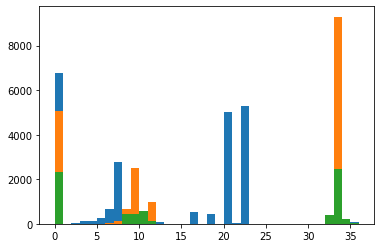

In [67]:

#"C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg"
def To_Data(img):
    name=img.split("/")
    Cut(img)
    H1,H2,H3=Color_hist("cuts/cut1_"+name[-2]+"_"+name[-1],
                        "cuts/cut2_"+name[-2]+"_"+name[-1],
                        "cuts/cut3_"+name[-2]+"_"+name[-1])
    
    H1=plt.hist(H1,36,(0,36))
    H2=plt.hist(H2,36,(0,36))
    H3=plt.hist(H3,36,(0,36))
    #H2_remake=[]
    #H3_remake=[]
    #for i in H2:
        #H2_remake.append(i+"2")
    #for i in H3:
        #H3_remake.append(i+"2")
    #H=H1+H2_remake+H3_remake    
    return H1,H2,H3

H1,H2,H3=To_Data("flower_pic/tree mallow/13651.jpeg")

,id,name_En,color_hist_1,color_hist_2,color_hist_3


ANN((等資料庫建完
===

In [14]:
#Approximate Nearest Neighbor
##施工中##



#施工中##

局部特徵
===

In [15]:
import numpy as np
import cv2 
img_1 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg')
img_2 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/16301.jpeg')
#gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#sift_1 = cv2.SIFT_create()
#kp_1 = sift_1.detect(img_1,None)
#img_1=cv2.drawKeypoints(img_1,kp_1,img_1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#sift_2 = cv2.SIFT_create()
#kp_2 = sift_2.detect(img_2,None)
#img_2=cv2.drawKeypoints(img_2,kp_2,img_2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


#cv2.imshow("SIFT", img_2)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


In [16]:
img_1 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg')
img_2 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/16301.jpeg')
orb = cv2.ORB_create(nfeatures = 50)
kp1_orb, des1_orb = orb.detectAndCompute(img_1,None)
kp2_orb, des2_orb = orb.detectAndCompute(img_2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches_orb = bf.match(des1_orb,des2_orb)

img_=cv2.drawKeypoints(img_2,kp2_orb,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imwrite("ORB.jpg", img_)
cv2.imshow("ORB", img_)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [17]:
#surf = cv2.SURF_create(40)
img_1 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/12769.jpeg')
img_2 = cv2.imread('C:/flowerpic/jpeg-224x224/val/iris/16301.jpeg')
sift = cv2.SIFT_create()

gray_1= cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
gray_2= cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)
kp1_sift, des1_sift = sift.detectAndCompute(gray_1,None)
kp2_sift, des2_sift = sift.detectAndCompute(gray_2,None)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches_sift = bf.match(des1_sift,des2_sift)

img=cv2.drawKeypoints(gray_2,kp2_sift,gray_2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite("SIFT.jpg", img)
cv2.imshow("SIFT", img)
cv2.waitKey(0)
cv2.destroyAllWindows()




In [18]:

print("DataType:",type(matches_orb[0]))
print("描述符之間的距離:",matches_orb[0].distance)# 越小越好
print("圖像中描述符的索引:",matches_orb[0].queryIdx)

print("DataType:",type(matches_sift[0]))
print("描述符之間的距離:",matches_sift[0].distance)
print("圖像中描述符的索引:",matches_sift[0].queryIdx)



DataType: <class 'cv2.DMatch'>
描述符之間的距離: 59.0
圖像中描述符的索引: 1
DataType: <class 'cv2.DMatch'>
描述符之間的距離: 198.2296600341797
圖像中描述符的索引: 0
